<a href="https://colab.research.google.com/github/Samasth/Continual_Learning/blob/main/Continual_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project - 2 - Continual Learning (CL) for Robotic Perception**


We use Pytorch to build a Neural network model based on the paper "Discriminative Variational Autoencoder
for Continual learning with generative
replay". We use MNIST and Rotated MNIST dataset as used in the paper for showing our results.

Generative replay (GR) is a method to alleviate catastrophic forgetting in continual learning (CL) by generating previous task data and learning them together with the data from new tasks. We use discriminative variational autoencoder (DiVA) to address the GR-based CL problem.

**Installing all required Packages**

In [ ]:
!pip3 install torch torchvision
!pip3 install idx2numpy
import matplotlib.pyplot as plt
import numpy
import scipy.ndimage
import torch 
import torchvision
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import copy
import os
from PIL import *
import random
import PIL.Image
import idx2numpy
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import scipy.ndimage
import numpy

  Created wheel for idx2numpy: filename=idx2numpy-1.2.2-cp36-none-any.whl size=8032 sha256=426ce873589e0ee702a8f3a5d5cc4b8483b9151f4c61f5c66053bd85f4e917e6
  Stored in directory: /root/.cache/pip/wheels/7a/b5/69/3e0757b3086607e95db70661798fdf98a77a0bb79c54e1f320
Successfully built idx2numpy


**Mounting Google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Downloading the MNIST Dataset**

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1)),
    transforms.Lambda(lambda tensor:tensor_round(tensor))
])
mnist_train  = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test  = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
batch_size = 64
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)    
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True) 

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


**Defining the Network**


Let us formulate the problem concretely. We have two tasks here for the network to learn. The first task is to learn to classify normal MNIST digits. The second task is to learn to classify rotated MNIST digits. With a normal feed-forward Neural network trained sequentially on these tasks, we observe that the network "forgets" task1 once it finished training on task2. This type of forgetting previous tasks is referred to as Catastrohpic forgetting.This is due to the difference in probability distribution of both the datasets. 

The overall idea to overcome catastrophic forgetting is to replay the past "memories" given that we don't have access to past tasks data. It has also been found in many studies that in some parts of brain such as Hippocampus, this generative replay mechanism is used for retaining knowledge about several tasks. Therefore, we need a generative model that can produce samples closely belonging to the original distribution so that we could use them in addition to the new task data and train the network which would theoretically let the network retain knowledge about the previous tasks. The neural network we implemented has two main class of networks namely Variational autoencoder (generative model) and a classification network.

**Variational Autoencoder**

Variational Autoencoders are a class of neural networks that were first proposed in DP Kingma and Max Welling (2014) are essentially a combination of neural networks and probabilistic graphical models. In probabilistic graphical models, the problem of inference focuses on obtaining the posterior distribution p(z│x) which essentially infers the values of latent variables given an observation. However, computing this posterior distribution is intractable because of the term p(x) present in equation as shown below.

\begin{equation}
p(z│x)= p(x│z)p(z)/p(x)     
\end{equation}

\begin{equation}
p(x)= ∫p(x│z)p(z)dz
\end{equation}

Computing the above integral is intractable because of the large number of possible latent variable settings and the dimension of the latent variables. Therefore, a tractable approximate posterior q(z│x) such as a Gaussian distribution is introduced and is made close to the true posterior p(z│x) by adjusting its parameters thereby eliminating the need to compute the above integral. 

The objective now is to bring the approximate posterior distribution q(z│x) as close as possible to the original posterior p(z│x). A similarity metric between probability distributions derived from information theory called as the KL Divergence or relative entropy as defined below is used for quantification.


\begin{equation}
KL ( q(z│x)  ,p(z│x) ) = E q [log q(z│x)] – E q [log p(x,z)] + log p(x)
\end{equation}

So, the parameters of the tractable distribution q(z│x) learned during the optimization will minimize the above divergence and bring it close to the original distribution. If we observe the RHS of the above equation, log p(x) is a constant for a given observation and hence, minimizing E q [log q(z│x)] – E q [log p(x,z)] is sufficient for minimizing the divergence. 

\begin{equation}
L =  E q [ log p ( x , z ) ]  -  E q [ log q ( z | x ) ]                                   
\end{equation}

Substituting L into the divergence equation, we obtain the following

\begin{equation}
KL ( q(z│x)  ,p(z│x) ) = - L + log p(x)                               
\end{equation}

\begin{equation}
log p(x) = KL ( q(z│x)  ,p(z│x) ) + L                                                     
\end{equation}

Since we know that KL ≥ 0, L acts as a lower bound for log p(x) and is referred as Variational lower bound. From equation (4), as the LHS is a constant, minimizing the KL Divergence is equivalent to maximizing the Lower bound L. This is very crucial because the lower bound is easier to optimize as we will see further. If we expand the logarithm in the first term of equation above and rewrite the equation, we get the following 

\begin{equation}
L =  E q(z|x) [ log p( x|z) ]   -  KL ( q(z│x)  ,p(z│x) 
\end{equation}

This is the point where we bring in the neural networks and create variational autoencoders. The final step is to parametrize the approximate posterior qθ (z∣x,λ) with an inference network (or encoder) that takes as input data x and outputs parameters λ. We parametrize the likelihood p(x│z) with a generative network (or decoder) that takes latent variables and outputs parameters to the data distribution pϕ (x∣z). The inference and generative networks have parameters θ and ϕ respectively. The parameters are typically the weights and biases of the neural networks. Now, the first term of the equation above can be interpreted as the reconstruction error as in a traditional autoencoder. 

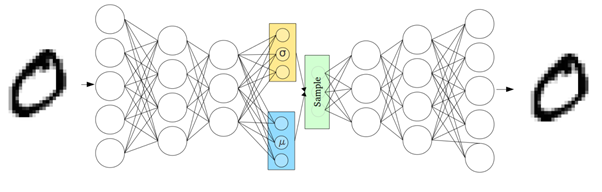

We make an assumption about the prior and posterior distributions on z before going to the second term (KL divergence). We assume that p (z) is a centered isotropic multivariate  Gaussian N (z;0,I) and the posterior q (z |x ) to be Gaussian as well with the mean and variance produced by the encoder network. This is done to obtain a closed form expression for the KL divergence present in the lower bound equation. Maximizing the lower bound will force the encoder network to produce samples that closely belong to unit Gaussian distribution. Similarly, maximizing the lower bound will force the decoder to transform the latent samples drawn from the posterior distribution to realistic looking images that resembles the ones in the training data thereby maximizing p (x |z).

The encoder network is similar to that of a Variational autoencoder where it takes as input 28x28 image and outputs parameters of a gaussian distribution. In a traditional Variational autoencoder, these parameters are pushed to form a isotrpoic gaussian distribution ( Mean = 0 and Covariance = I) or in other words, the prior distribution on z (latent space) is assumed to be isotropic gaussian. This constraint is taken care by a KL divergence between the distribution produced by the encoder and the prior distribution. Once training of encoder and decoder networks are done, the encoder can be removed and latent vectors can be sampled from prior distribution(Isotropic gaussian distribution) and fed into the decoder network. The output of decoder would be semantically sound digits. However, in this kind of generation, we don't have control over the generation of digits. 
In our model, we would need control over generation of digits as these would be used to create a dataset with uniform number of classes. Therefore, instead of restricting the prior to be a fixed isotropic gaussian, we create a new network called Prior network which would produce a new distribution of each class by taking in one-hot vector form of digit classes and outputting mean and variance of the distribution produced. So the modification from the original VAE would be that the KL Divergence term would be between the distribution produced by the prior and the encoder. When this network is trained, we could simply eliminate the encoder network and feed into the prior the one-hot vector of desired class and get the reconstructed image of that digit thereby enabling class conditional generation.

**Classification Network**

In this paper, along with the Variational encoder loss, they thought of imposing another loss term which was the mutual information I(c;z). The mutual information gave the amount of information inferred about c given z. This loss term when applied to our network translates to a classification loss or cross entropy loss. Therefore, we take the sample drawn from the encoder and feed it to classification network along with the decoder network. When doing backprop, in reducing the classification error, the weights would be tuned in such a way that the sample drawn from the encoder would become more informative about the class it represents. And because of the KL divergence pushing the posterior and prior distribution closer, we would eventually have the prior distributions more representative of the classes hence making class conditional generation even more more accurate. 


![alt text](https://drive.google.com/uc?id=1bloa42HsWsRsQ5O1KbAO2M09KHMXsLJ8)

In [ ]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1,stride=2),   
                        nn.ReLU(), 
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1,stride=2),   
                        nn.ReLU(), 
                        nn.BatchNorm2d(64),  
                        nn.Conv2d(64,128,3,padding=1,stride=2),   
                        nn.ReLU(), 
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,256,3,padding=1,stride=2),   
                        nn.ReLU(), 
                        nn.BatchNorm2d(256),
                        Flatten(),
                        nn.Linear(2*2*256,256),
                        nn.ReLU(),
                        nn.BatchNorm1d(256),
                        nn.Linear(256,256),
                        nn.Softplus()
                      
                   )
        
    def reparametrize(self, mu, logvar):
        var = logvar.exp()
        std = var.sqrt()
        eps = Variable(torch.FloatTensor(std.size()).normal_())
        return eps.mul(std).add(mu)
        


    def forward(self, x):
        
        h = self.layer(x)  
        h=h.view(-1,256)
        mu = h[:, :128]
        logvar = h[:, 128:]
        z = self.reparametrize(mu, logvar)
        return z,mu,logvar


encoder = Encoder()     

In [ ]:

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dlayer1 = nn.Sequential(
                        nn.Linear(128,128*1*1)
                      
                   )
        self.dlayer2 = nn.Sequential(
                        nn.ConvTranspose2d(128,128,3,2,0,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,0),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,0),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,0),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.dlayer3 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,0),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,0),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.Sigmoid()
        )
        



    def forward(self, x):
        
        h = self.dlayer1(x)  
        h=h.view(-1,128,1,1)
        h = self.dlayer2(h)
        h = self.dlayer3(h)
        
        return h


decoder = Decoder()     

In [ ]:

class Prior(nn.Module):
    def __init__(self):
        super(Prior, self).__init__()
        self.layer = nn.Sequential(
                        nn.Linear(10,256),
                        nn.Softplus()
                      
                   )
        

    def forward(self, x):
        
        h = self.layer(x)  
        h=h.view(-1,256)
        mu = h[:, :128]
        logvar = h[:, 128:]
        
        return mu,logvar


prior = Prior()     

In [ ]:

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
                        nn.Linear(128,10),
                        nn.Softmax()
                      
                   )
        

    def forward(self, x):
        
        h = self.layer(x)  
        h=h.view(-1,10)

        return h


classifier = Classifier()   

Validate_task1 function takes in normal looking MNIST validation/test data ( input images of 28x28 pixels), feeds it to the encoder, and feeds the sample drawn from the parameters produced by the encoder to the classification network. The accuracy is computed from the output of the classification network.

In [ ]:
def validate_task1(data):
  # To get validation accuracy = (correct/total)*100.
  total = 0
  correct = 0
  for i,(images,labels) in enumerate(data):
    images = Variable(images)
    e,mu,logvar = encoder(images)
    h = classifier(e)

    value,pred = torch.max(h,1)
    pred = pred.data.cpu()
    total += h.size(0)
    correct += torch.sum(pred == labels)
  return correct*100./total


**Training - Task1 ( Normal MNIST )**

The training involves the forward prop and backward prop. First, the input image is fed to the encoder after which a sample is drawn from the resulting parameters. Simultaneously, the corresponding label is fed into the prior in one-hot vector form and the prior network produces parameters of the prior distribution for that particular class. Now, we feed the drawn sample from the encoder to both the decoder and the classification network. The classification network produces class probabilities and the decoder produces reconstructed image. The loss is computed as mentioned above. The total loss comprises of MSE of reconstructed and original image, Cross entropy loss between the probabilities and original class label (in one-hot form) and the KL divergence between the prior and posterior distribution. Having computed the loss, we backpropagate it through the networks. 

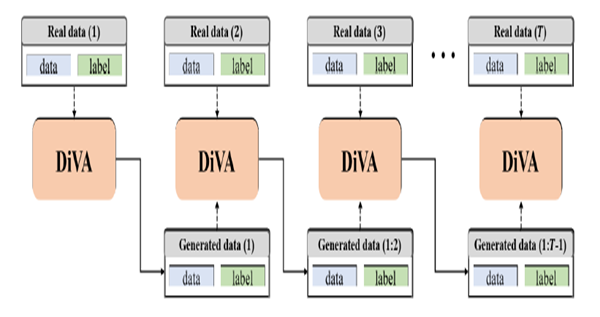

**Hyperparameters**

Learning rate = 0.0007

Epochs = 35

Batch size = 64

Latent space Dimension = 128

The input_condition method converts the labels into one hot encoded format.

In [ ]:
def input_condition(labels):
  pr = torch.zeros(labels.size(0),10)
  l = len(labels)
  for i in range(l):
    pr[i,labels[i].int()] = 1
  return pr

def train_model_task1(data):
  params = list(encoder.parameters()) + list(decoder.parameters()) + list(prior.parameters()) + list(classifier.parameters())
  optimizer = torch.optim.Adam(params,lr = 0.0007)
  loss_class = nn.CrossEntropyLoss()
  loss_recons = nn.MSELoss()
  ls=[]
  n_epoch = 35
  lambd = 1
  weight_mse = 1
  for e in range(n_epoch):
    print("Epoch:",e)
    for i,(images,labels) in enumerate(data):
      images = Variable(images)
      labels = Variable(labels)
      optimizer.zero_grad()
      pr = input_condition(labels)
      prior_mean,prior_logvar = prior(pr)
      e,post_mean,post_logvar = encoder(images)
      prior_std = prior_logvar.exp().sqrt()
      post_std = post_logvar.exp().sqrt()
      d = decoder(e)
      pred = classifier(e)

      mse_loss = loss_recons(images,d)
      classifier_loss = loss_class(pred,labels)
      kl_loss = (0.5/(128*batch_size))*(torch.sum(torch.log(post_std)) - torch.sum(torch.log(prior_std)) - 128 + torch.sum( (prior_std + pow(post_mean-prior_mean,2))/post_std))
      total_loss = weight_mse*mse_loss + lambd*classifier_loss + kl_loss

      total_loss.backward()
      optimizer.step() 
  #    print("Loss at Epoch:",e, total_loss.item())
      ls.append(total_loss.item())
    print(total_loss.item())   
  
  return ls


Since we would need this model for comparing the effect of forgetting with and without generative replay, we store this model in drive.
Upon calling the train_task1 function, we list of losses for each epoch. Once the training is done, we call validate_task1 to see the classification performance of the above defined network.
We observe that the classification accuracy is over 99% and this indicates that the model has significantly learned and gained insights into the patterns in the input data.

In [ ]:
loss = train_model_task1(train_loader)

torch.save(encoder.state_dict(), '/content/drive/My Drive/encoder.pt')
torch.save(decoder.state_dict(), '/content/drive/My Drive/decoder.pt')
torch.save(prior.state_dict(), '/content/drive/My Drive/prior.pt')
torch.save(classifier.state_dict(), '/content/drive/My Drive/classifier.pt')


acc = validate_task1(test_loader)
print("Accuracy Trained on Task1 and tested on Task1 is:",acc.item())

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy Trained on Task1 and tested on Task1 is: 99.08999633789062


We now observe the decoder's performance by feeding in input images to the encoder, drawing a sample from the distribution parameters ( mean and variance ) and finally feeding that to the decoder. Although there is some amount of randomness in drawing the sample from the encoder's output distribution parameters, the reconstructed image is reasonably clear and identical to the original image.

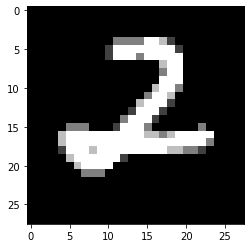

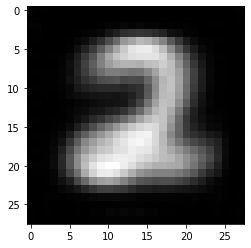

In [ ]:
# Testing Task1 Reconstruction (Normal MNIST)

for images,labels in test_loader:
  e,_,_ = encoder(images)
  d = decoder(e)
  d = d.view(64,28,28)
  dp = d[0].view(28,28)
  dp = dp.data.numpy()
  ep = images[0].view(28,28)
  break
plt.imshow(ep,cmap='gray')
plt.show()
plt.imshow(dp,cmap='gray')  



We now test the class-conditional generation ability of the trained network. We feed in a one-hot vector of digit 1 label into the prior network. The mean and variance parameters produced by the prior network is then used to draw a sample from the probability distribution and then fed to the decoder network. It is observed that the output of the decoder is clear and corresponds to the label fed into the prior network.

Class : tensor(1)


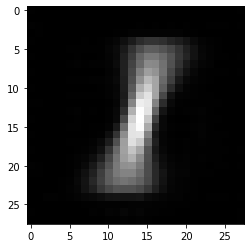

In [ ]:
# Testing prior network - Class conditional generation
for images,labels in train_loader:
  t = torch.zeros(images.size(0),10)
  for i in range(t.size(0)):
    t[i,labels[i]] = 1
  
  pr_mu,pr_logvar = prior(t)
  var = pr_logvar.exp()
  std = var.sqrt()
  eps = Variable(torch.FloatTensor(std.size()).normal_())
  r = eps.mul(std).add(pr_mu)
  d = decoder(r)
  k=21
  
  print("Class :",labels[k])
  dp = d[k].view(28,28).data.numpy()
  plt.imshow(dp,cmap='gray')
  break

Rotate_dataset is a function which takes in normal MNIST images and an angle as input and returns the input images rotated by the given angle. This function is used for creating the rotated MNIST dataset.

In [ ]:
def rotate_dataset(d, rotation):
    
    result = torch.Tensor(d.size(0), 28,28)
    tensor = transforms.ToTensor()

    for i in range(d.size(0)):
        img = Image.fromarray(d[i].view(28,28).numpy())
        result[i] = tensor(img.rotate(rotation))
    return result

Below, we create the train dataset of rotated images in which the rotation angle is randomly chosen between 0-360 for each digit. Once the rotation is completed we use DataLoader to load the dataset for using it for training.

In [ ]:
import torch.utils.data as data_utils

images_rotate = torch.randn(0)
labels_rotate = torch.randn(0)
for images,labels2 in train_loader:
    images = Variable(images)
    r = random.randint(0,360) 
    temp_images_rotate = rotate_dataset(images,r).view(images.size(0),1,28,28)
    images_rotate = torch.cat((images_rotate, temp_images_rotate))
    labels_rotate = torch.cat((labels_rotate.long(), labels2.long()))

#images_rotate = torch.FloatTensor(images_rotate)
mnist_train_rotate = data_utils.TensorDataset(images_rotate, labels_rotate)
rotate_loader =  DataLoader(mnist_train_rotate, batch_size=batch_size, shuffle=True)

Now that the model is trained with task1 ( Normal MNIST ) and its performing extraordinarily well, we need to train the already trained model with task2 ( Rotated MNIST ) and see if it "forgets" task1. Similar to validate_task1, validates_task2 function computes the accuracy on task2 data. And train_model_task2 is similar to that for task1 and different in the sense that the data is just rotated. The training procedure is identical to that of task1.

**Hyperparameters**

Learning Rate = 0.001

Batch Size = 64

Epochs = 35


In [ ]:
def validate_task2(data):
  # To get validation accuracy = (correct/total)*100.
  total = 0
  correct = 0
  for i,(images,labels) in enumerate(data):
    images = Variable(images)
    r = random.randint(0,360) 
    images_rot = rotate_dataset(images,r).view(images.size(0),1,28,28)    
    e,mu,logvar = encoder(images_rot)
    h = classifier(e)

    value,pred = torch.max(h,1)
    pred = pred.data.cpu()
    total += h.size(0)
    correct += torch.sum(pred == labels)
  return correct*100./total

def train_model_task2(data):
  # Directly trains on task2 WITHOUT generative replay
  params = list(encoder.parameters()) + list(decoder.parameters()) + list(prior.parameters()) + list(classifier.parameters())
  optimizer = torch.optim.Adam(params,lr = 0.001)
  loss_class = nn.CrossEntropyLoss()
  loss_recons = nn.MSELoss()
  ls=[]
  n_epoch = 35

  for e in range(n_epoch):
    print("Epoch:",e)
    for images,labels in data:
      images = Variable(images)
      #r = random.randint(90,270) 
      #images_rot = rotate_dataset(images,r).view(images.size(0),1,28,28)
      labels = Variable(labels)
      optimizer.zero_grad()
      pr = input_condition(labels)
      prior_mean,prior_logvar = prior(pr)
      e,post_mean,post_logvar = encoder(images)
      prior_std = prior_logvar.exp().sqrt()
      post_std = post_logvar.exp().sqrt()
      d = decoder(e)
      pred = classifier(e)

      mse_loss = loss_recons(images,d)
      classifier_loss = loss_class(pred,labels)
      kl_loss = (0.5/(batch_size*128))*(torch.sum(torch.log(post_std)) - torch.sum(torch.log(prior_std)) - 128 + torch.sum( (prior_std + pow(post_mean-prior_mean,2))/post_std))
      total_loss = mse_loss + classifier_loss + kl_loss

      total_loss.backward()
      optimizer.step() 
  #    print("Loss at Epoch:",e, total_loss.item())
      ls.append(total_loss.item())
    print(total_loss.item())   
  
  return ls



Once the training is completed we compute the accuracy of the model on the rotated MNIST dataset (task2) for which we get around 95%. But when we test the model on the task1 dataset (Normal MNIST), the accuracy falls low to around 41% which clearly shows that our model is forgetting what it had learned before.

In [ ]:
# Observing Catastrophic forgetting

loss = train_model_task2(rotate_loader)

acc2 = validate_task2(test_loader)
print("Accuracy in task2-Training model on task2 after task1:",acc2)
acc1 = validate_task1(test_loader)
print("Accuracy in task1-Training model on task2 after task1:",acc1)


Epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


1.7951349020004272
Epoch: 1
1.8179446458816528
Epoch: 2
1.9221787452697754
Epoch: 3
1.8431382179260254
Epoch: 4
1.8402109146118164
Epoch: 5
1.778361201286316
Epoch: 6
1.8711947202682495
Epoch: 7
1.851608157157898
Epoch: 8
1.8025068044662476
Epoch: 9
1.7701443433761597
Epoch: 10
1.8385965824127197
Epoch: 11
1.8024822473526
Epoch: 12
1.8419079780578613
Epoch: 13
1.7741671800613403
Epoch: 14
1.9232409000396729
Accuracy in task2-Training model on task2 after task1: tensor(95.3800)
Accuracy in task1-Training model on task2 after task1: tensor(41.2200)


To solve the problem of forgetting the model when trained with new dataset, we perform the steps below. We use the prior network we had trained before to generate samples of task1 data, pass it to the decoder network to generate data samples for our Normal MNIST dataset. So even though the network has only seen the task1 data once, it can generate new samples of the same kind and use it as training data along with that of task2. The difference to above method is that instead of training the model on task2 data, we concatenate task2 data and generated task1 data (By the prior network being fed to the decoder network) and use the combination as task2 training data. This idea assumes the fact that the generated task1 data will enable the network to retain knowledge about task1 even though its being trained with task2 data. 

In [ ]:

# Generating the Pseudo data

pseudo_data = torch.randn(0)
for i in range(10):

  tem = torch.zeros(6000,10)
  tem[:,i] = torch.ones(6000)
  mu,logvar = prior(tem)
  prior_std = logvar.exp().sqrt()
  eps = Variable(torch.FloatTensor(prior_std.size()).normal_())
  r = eps.mul(prior_std).add(mu)   
  d = decoder(r)
  pseudo_data = torch.cat((pseudo_data,d))
  print(i)
pseudo_data - torch.FloatTensor(pseudo_data)
labels = torch.cat((0*torch.ones(6000),1*torch.ones(6000),2*torch.ones(6000),3*torch.ones(6000),4*torch.ones(6000),5*torch.ones(6000),6*torch.ones(6000),7*torch.ones(6000),8*torch.ones(6000),9*torch.ones(6000)))
print(labels.size())
labels = labels.view(60000).long()
print(labels)
print(labels.size())
import torch.utils.data as data_utils



pdataset = data_utils.TensorDataset(pseudo_data, labels)

concat_dataset = torch.utils.data.ConcatDataset([mnist_train_rotate, pdataset])
combined_dataset_loader = data_utils.DataLoader(concat_dataset, batch_size=32, shuffle=True)
  


In [ ]:
# Training Task2 with generative replay
encoder.load_state_dict(torch.load('/content/drive/My Drive/encoder.pt'))
decoder.load_state_dict(torch.load('/content/drive/My Drive/decoder.pt'))
prior.load_state_dict(torch.load('/content/drive/My Drive/prior.pt'))
classifier.load_state_dict(torch.load('/content/drive/My Drive/classifier.pt'))
loss = train_model_task1(combined_dataset_loader)
acc5 = validate_task1(test_loader)
print("Accuracy in task1-Training model on task2 after task1(With Generative Replay):",acc5)
acc1 = validate_task2(test_loader)
print("Accuracy in task2-Training model on task2 after task1(With Generative Replay):",acc1)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy in task1-Training model on task2 after task1(With Generative Replay): tensor(90.9000)
Accuracy in task2-Training model on task2 after task1(With Generative Replay): tensor(89.4100)


**Conclusion**

Once we prepare the combined dataset, we train the already task1 trained model on it by first loading the saved model. Once the training was completed, we could observe that the accuracy on task1 data was around 91% in comparison to 41% which we got without any replay. This huge improvement in performance was only because of generative replay mechanism. And the performance on task2 was around 90% which was quite reasonable considering that the network had to learn two different dataset distribution with just one network. Therefore, we conclude that generative replay using Discriminative Variational Autoencoder yields an enormous improvement in performance thereby overcoming Catastrophic forgetting.
